In [1]:
using Pkg
Pkg.develop("QuantumDots")
Pkg.activate(pwd())
Pkg.instantiate()
using QuantumDots, QuantumDots.BlockDiagonals, LinearAlgebra
using Plots
using DifferentialEquations

   Resolving package versions...


  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Project.toml`
  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Manifest.toml`


  Activating project at `c:\Users\svens\.julia\dev\QuantumDots\examples`

In [2]:
struct MajoranaWrapper{B,D}
    basis::B
    majoranas::D
    function MajoranaWrapper(basis, labels=collect(Base.product(keys(basis), (:a, :b))))
        N = length(basis)
        length(labels) == 2 * N || throw(ErrorException("Number of majoranas is not twice the fermion number"))
        majA = map(f -> f + f', basis)
        majB = map(f -> 1im * (f - f'), basis)
        majs = vcat(majA, majB)
        dA = QuantumDots.dictionary(zip(labels[1:N], values(majA)))
        dB = QuantumDots.dictionary(zip(labels[N+1:2N], values(majB)))
        d = merge(dA, dB)
        new{typeof(basis),typeof(d)}(basis, d)
    end
end
Base.getindex(g::MajoranaWrapper, i...) = g.majoranas[i...]

In [3]:
c = FermionBasis(1:2)
γ = MajoranaWrapper(c, 0:3)

MajoranaWrapper{FermionBasis{2, Int64, SparseArrays.SparseMatrixCSC{Int64, Int64}, QuantumDots.NoSymmetry}, Dictionaries.Dictionary{Int64, SparseArrays.SparseMatrixCSC{T, Int64} where T}}(FermionBasis{2,Int64,SparseArrays.SparseMatrixCSC{Int64, Int64},QuantumDots.NoSymmetry}:
keys = {1, 2}, {0 = sparse([2, 1, 4, 3], [1, 2, 3, 4], [1, 1, -1, -1], 4, 4), 1 = sparse([3, 4, 1, 2], [1, 2, 3, 4], [1, 1, 1, 1], 4, 4), 2 = sparse([2, 1, 4, 3], [1, 2, 3, 4], Complex{Int64}[0 - 1im, 0 + 1im, 0 + 1im, 0 - 1im], 4, 4), 3 = sparse([3, 4, 1, 2], [1, 2, 3, 4], Complex{Int64}[0 - 1im, 0 - 1im, 0 + 1im, 0 + 1im], 4, 4)})

In [4]:
smooth_step(x, k) = 1 / 2 + tanh(k * x) / 2
# Give the value of the three deltas at time t in the three point majorana braiding protocol
function braiding_deltas(t, T, Δmax, Δmin, k, args...)
    Δ1 = Δtrajectory(t, T, Δmax, Δmin, k)
    Δ2 = Δtrajectory(t + T / 3, T, Δmax, Δmin, k)
    Δ3 = Δtrajectory(t + 2T / 3, T, Δmax, Δmin, k)
    return Δ1, Δ2, Δ3
end
function Δtrajectory(t, T, Δmax, Δmin, k, args...)
    dΔ = Δmax - Δmin
    tp = mod(t, T) - T / 12
    Δmin + dΔ * smooth_step(tp - 1T / 6, k) - dΔ * smooth_step(tp - 4T / 6, k)
end

Δtrajectory (generic function with 1 method)

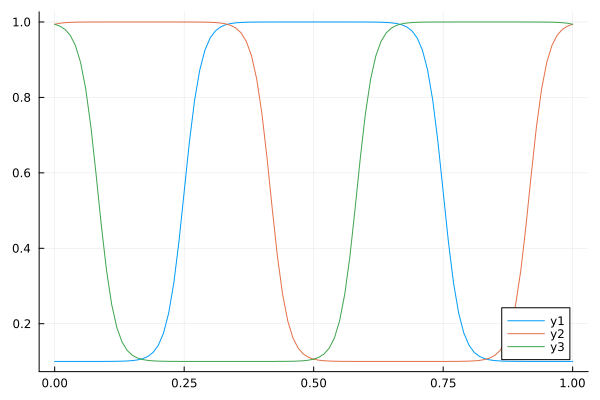

In [5]:
let T = 1, Δmax = 1, Δmin = 0.1, k = 30
    ts =  0:0.01:T
    deltas = stack([braiding_deltas(t, T, Δmax, Δmin, k) for t in ts])'
    plot(ts,deltas)
end

In [6]:
const γ01 = Matrix(1.0im * γ[0] * γ[1])
const γ02 = Matrix(1.0im * γ[0] * γ[2])
const γ03 = Matrix(1.0im * γ[0] * γ[3])
const γs = (γ01, γ02, γ03)

(ComplexF64[0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 1.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 1.0im 0.0 + 0.0im; 0.0 + 0.0im -0.0 - 1.0im 0.0 + 0.0im 0.0 + 0.0im; -0.0 - 1.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im], ComplexF64[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im -1.0 + 0.0im], ComplexF64[0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im -1.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im -1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im])

In [7]:
# function H((T, Δmin, Δmax, k), t)
#     Δs = braiding_deltas(t, T, Δmax, Δmin, k)
#     _H(Δs)
#     # Δ1, Δ2, Δ3 = Δs
#     # @. Δ1 * γ01 + Δ2 * γ02 + Δ3 * γ03
# end
function H((T, Δmin, Δmax, k), t, W)
    Δs = braiding_deltas(t, T, Δmax, Δmin, k)
    _H(W .+ Δs)
end
_H(Δs, γs=γs; cache=zero(first(γs))) = foldl((H, (γ, Δ)) -> H .+= Δ .* γ, zip(γs, Δs), init=cache)


_H (generic function with 2 methods)

In [8]:
function heisenberg!(du, u, p, t, W=0)#, p, t, args...)
    ham = H(p, t, W)#p, t, args...)
    mul!(du, ham, u, 1im, 0)
    mul!(du, u, ham, -1im, 1)
    return du
end

heisenberg! (generic function with 2 methods)

In [9]:
u0 = 1.0complex(Matrix(γ[1]))
T = 0.1
k = 100 / T
Δmax = 1e2 / T
Δmin = Δmax * 1e-2
σ = Δmax/10
p = (T, Δmin, Δmax, k)
tspan = (0.0, 2T)

prob = ODEProblem(heisenberg!, u0, tspan, p)
W = OrnsteinUhlenbeckProcess(1/(T), 0.0, σ, 0.0, zeros(3), zeros(3))
rodeprob = RODEProblem(heisenberg!, u0, tspan, p, noise=W, rand_prototype=zeros(Float64, 3), )
ts = range(0, tspan[2], 300)
deltas = stack([braiding_deltas(t, p...) for t in ts])'
plot(ts, deltas);

In [10]:
@time sol = solve(prob, saveat=ts)
@time rodesol = solve(rodeprob, saveat=ts, dt = T/100000, abstol=1e-3, reltol=1e-8)

 12.033828 seconds (17.98 M allocations: 1.120 GiB, 4.48% gc time, 99.72% compilation time)


 59.123593 seconds (79.67 M allocations: 30.193 GiB, 6.83% gc time, 99.09% compilation time)


retcode: Success
Interpolation: 1st order linear
t: 300-element Vector{Float64}:
 0.0
 0.0006688963210702341
 0.0013377926421404682
 0.002006688963210702
 0.0026755852842809363
 0.0033444816053511705
 0.004013377926421404
 0.0046822742474916385
 0.005351170568561873
 0.006020066889632107
 ⋮
 0.19464882943143813
 0.19531772575250836
 0.1959866220735786
 0.19665551839464884
 0.19732441471571907
 0.1979933110367893
 0.19866220735785953
 0.19933110367892976
 0.2
u: 300-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]
 [0.0 + 0.0im -0.006060929415048459 - 0.006120478341872219im 0.9999442843927918 - 0.006120875676473184im 0.0 + 0.0im; -0.006060929415048457 + 0.006120478341872221im 0.0 + 0.0im 0.0 + 0.0im 0.9999442843927918 - 0.006120875676473186im; 0.9999442843927918 + 0.006120875676473186im 0.0 + 0.0im 0.0 + 

In [11]:
γ_projections(sol::AbstractMatrix) = [abs(tr(γ * sol)) for γ in (γ[1], γ[2], γ[3])]
γ_projections(sol, ts::AbstractVector = ts) = transpose(reduce(hcat, map(t->γ_projections(sol(t)), ts)))

γ_projections (generic function with 3 methods)

In [12]:
projs = γ_projections(sol)
rodeprojs = γ_projections(rodesol);

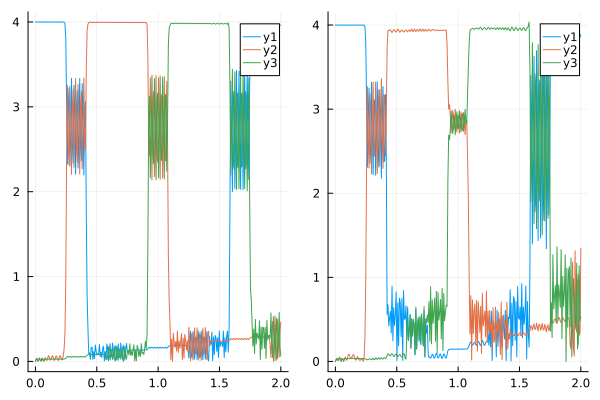

In [13]:
plot(plot(ts ./ T, projs), plot(ts ./ T, rodeprojs))

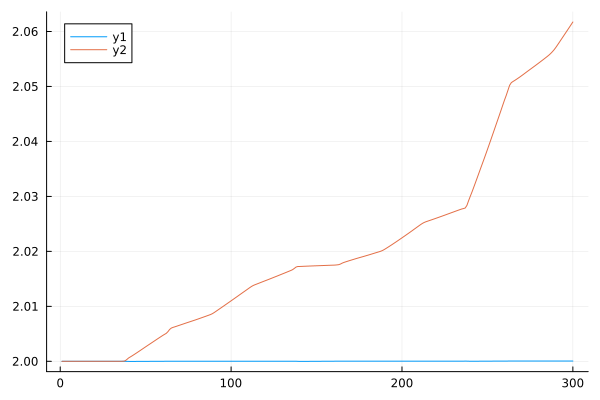

In [14]:
plot(map(norm, sol))
plot!(map(norm, rodesol))

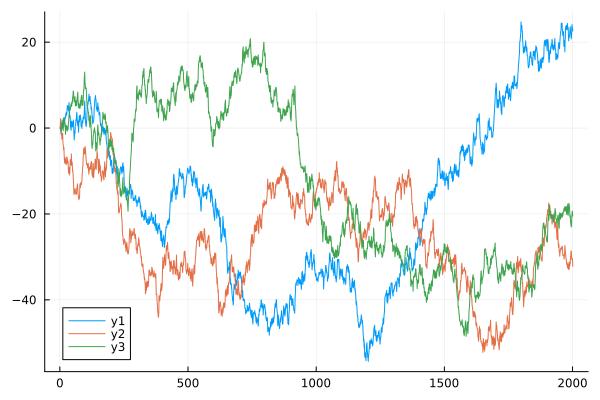

In [15]:
plot(stack(rodesol.W.u)'[1:100:end,:])

In [16]:
function prob_func(prob, i, repeat)
    W = OrnsteinUhlenbeckProcess(1/(T), 0.0, Δmax/10, 0.0, zeros(3), zeros(3))
    remake(prob; noise=W)
end
ensembleprob = EnsembleProblem(rodeprob;
    prob_func,
    output_func=(sol, i) -> ((map(s -> push!(γ_projections(s), norm(s)), sol)), false))

EnsembleProblem with problem RODEProblem

In [17]:
enssol = solve(ensembleprob, EnsembleThreads(), #ImplicitEulerHeun(symplectic=true, theta=1 / 2, autodiff=false),
    trajectories=50, saveat=ts, abstol=1e-6, reltol=1e-8, dt = T/100000)

EnsembleSolution Solution of length 50 with uType:
Vector{Vector{Float64}}

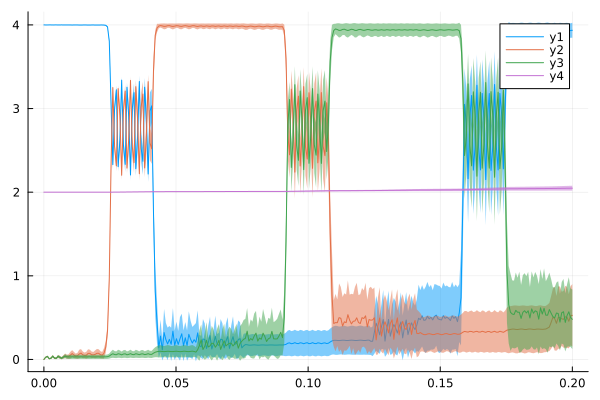

In [18]:
using DifferentialEquations.EnsembleAnalysis
mv = [timestep_meanvar(enssol, n) for n in 1:size(enssol, 1)];
v = stack(last.(mv))'
m = stack(first.(mv))'
plot(ts, m; ribbon = (sqrt.(v),sqrt.(v)))